In [1]:
import os
from pathlib import Path
from collections import defaultdict, Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------------------
PHOTO_DIR = Path("photo")
LABELS_DIR = Path("labels")


In [2]:

suffix_counter = Counter()

image_paths = list(PHOTO_DIR.glob("*.jpeg")) + list(PHOTO_DIR.glob("*.jpg"))

# (.+?) -захватывает все символы в начале (базовое имя).
# ([a-zA-Z]+)$ - захватывает одну или более букв в самом конце строки (суффикс).
pattern = re.compile(r"(.+?)([a-zA-Z]+)$")

print(f"Анализ {len(image_paths)} файлов...")

for img_path in image_paths:
    stem = img_path.stem
    
    match = pattern.match(stem)
    
    if match:
        base_name = match.group(1)
        suffix = match.group(2)

        if not base_name[-1].isalpha():
            suffix_counter[suffix] += 1
        else:
            suffix_counter["<no_suffix>"] += 1
    else:
        suffix_counter["<no_suffix>"] += 1
        
print("\n--- Результаты анализа суффиксов ---")

    
sorted_suffixes = suffix_counter.most_common()
ignored_suffixes = {'dcf', 'dcm', 'dcr'}

print(f"Изображений без аугментации (или с суффиксами типа dcf/dcm): {suffix_counter.get('<no_suffix>', 0)}")

final_suffix_list = []
for suffix, count in sorted_suffixes:
    if suffix != "<no_suffix>" and suffix not in ignored_suffixes:
        final_suffix_list.append(suffix)

print(f"Найдено уникальных суффиксов аугментации: {len(final_suffix_list)}")
print("-" * 35)

print("Список суффиксов и их количество:")
for suffix in sorted(final_suffix_list):
    count = suffix_counter[suffix]
    print(f"  - '{suffix}': {count} раз")

print("\n" + "="*50)
final_suffix_list.sort(key=len, reverse=True)
print(final_suffix_list)
print("="*50)

Анализ 784 файлов...

--- Результаты анализа суффиксов ---
Изображений без аугментации (или с суффиксами типа dcf/dcm): 225
Найдено уникальных суффиксов аугментации: 69
-----------------------------------
Список суффиксов и их количество:
  - 'br': 8 раз
  - 'brflip': 4 раз
  - 'brl': 9 раз
  - 'brlflip': 3 раз
  - 'brlrot': 9 раз
  - 'brlrotflip': 2 раз
  - 'brlrotl': 9 раз
  - 'brlrotlflip': 1 раз
  - 'brrot': 8 раз
  - 'brrotflip': 1 раз
  - 'brrotl': 8 раз
  - 'brrotlflip': 2 раз
  - 'dcmt': 1 раз
  - 'dcrflip': 1 раз
  - 'dcrl': 27 раз
  - 'dcrlflip': 1 раз
  - 'dcrot': 26 раз
  - 'dcrotflip': 2 раз
  - 'dcrrot': 27 раз
  - 'dcrrotflip': 2 раз
  - 'dcrt': 1 раз
  - 'f': 19 раз
  - 'fflip': 2 раз
  - 'flip': 3 раз
  - 'r': 23 раз
  - 'rflip': 1 раз
  - 'rl': 22 раз
  - 'rlflip': 2 раз
  - 'rlt': 4 раз
  - 'rot': 34 раз
  - 'rotbr': 9 раз
  - 'rotbrflip': 3 раз
  - 'rotbrl': 9 раз
  - 'rotbrlflip': 2 раз
  - 'rotbrlrot': 9 раз
  - 'rotbrlrotflip': 1 раз
  - 'rotbrlrotl': 9 раз
  - '

In [3]:
AUG_SUFFIXES = sorted(final_suffix_list, key=len, reverse=True)

def is_augmented(filename_stem):
    for suffix in AUG_SUFFIXES:
        if filename_stem.endswith(suffix):
            base = filename_stem[:-len(suffix)]
            if base:
                is_also_suffix = False
                for s in AUG_SUFFIXES:
                    if base.endswith(s):
                        is_also_suffix = True
                        break
                if not is_also_suffix:
                    return True
    return False

def check_augmentation_theory():

    stats = {
        "augmented": {"has_label": 0, "no_label": 0},
        "base": {"has_label": 0, "no_label": 0}
    }

    image_paths = list(PHOTO_DIR.glob("*.jpeg")) + list(PHOTO_DIR.glob("*.jpg"))

    for img_path in image_paths:
        filename_stem = img_path.stem
        label_path = LABELS_DIR / (filename_stem + ".txt")
        has_label = label_path.exists()
        
        augmented = is_augmented(filename_stem)
        
        if augmented:
            if has_label:
                stats["augmented"]["has_label"] += 1
            else:
                stats["augmented"]["no_label"] += 1
        else: # базовый файл
            if has_label:
                stats["base"]["has_label"] += 1
            else:
                stats["base"]["no_label"] += 1

    print("--- Результаты проверки гипотезы ---")
    print(f"Гипотеза: 'Аугментированы только фото, относящиеся к категории НЕ НОРМА'")
    print("-" * 40)
    print("Статистика по изображениям:")
    print(f"  Аугментированные 'не норма' (есть метка): {stats['augmented']['has_label']}")
    print(f"  Аугментированные 'норма' (нет метки):   {stats['augmented']['no_label']}")
    print(f"  Базовые 'не норма' (есть метка):         {stats['base']['has_label']}")
    print(f"  Базовые 'норма' (нет метки):          {stats['base']['no_label']}")
    print("-" * 40)

    # --- Формулировка вывода ---
    print("Вывод:")
    if stats['augmented']['no_label'] == 0:
        print("Теория ПОДТВЕРДИЛАСЬ.")
    elif stats['augmented']['no_label'] < stats['augmented']['has_label'] * 0.1: # Если нормальных аугментаций очень мало
        print("Теория в целом ВЕРНА.")
    else:
        print("Теория НЕ ПОДТВЕРДИЛАСЬ.")
        print(f"   Найдено значительное количество ({stats['augmented']['no_label']}) аугментированных изображений 'нормы'.")
        print("   Аугментации, по-видимому, применялись к обоим классам.")


check_augmentation_theory()


--- Результаты проверки гипотезы ---
Гипотеза: 'Аугментированы только фото, относящиеся к категории НЕ НОРМА'
----------------------------------------
Статистика по изображениям:
  Аугментированные 'не норма' (есть метка): 494
  Аугментированные 'норма' (нет метки):   39
  Базовые 'не норма' (есть метка):         143
  Базовые 'норма' (нет метки):          108
----------------------------------------
Вывод:
Теория в целом ВЕРНА.


--- Анализ на уровне пациентов ---
Всего уникальных пациентов: 344
Пациенты с инородными телами ('не норма'): 224
Пациенты без инородных тел ('норма'): 120


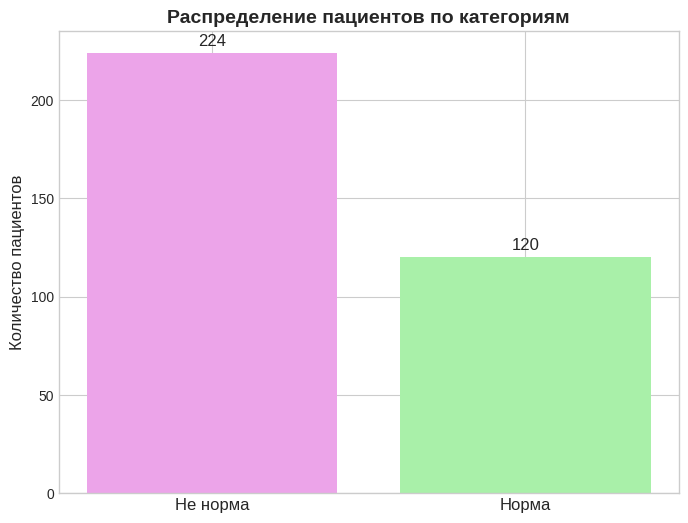

In [ ]:
def get_patient_id(filename_stem):

    # Извлекает "чистый" ID пациента из имени файла, удаляя суффиксы аугментации.

    cleaned_stem = filename_stem
    for suffix in AUG_SUFFIXES:
        if cleaned_stem.endswith(suffix):
            cleaned_stem = cleaned_stem[:-len(suffix)]
            break
    return cleaned_stem

patient_status = defaultdict(bool)

image_paths = list(PHOTO_DIR.glob("*.jpeg")) + list(PHOTO_DIR.glob("*.jpg"))

for img_path in image_paths:
    patient_id = get_patient_id(img_path.stem)
    if patient_status[patient_id]:
        continue
        
    label_path = LABELS_DIR / (img_path.stem + ".txt")
    if label_path.exists():
        patient_status[patient_id] = True # True означает "не норма"

norma_count = 0
ne_norma_count = 0
for status in patient_status.values():
    if status:
        ne_norma_count += 1
    else:
        norma_count += 1

print(f"--- Анализ на уровне пациентов ---")
print(f"Всего уникальных пациентов: {len(patient_status)}")
print(f"Пациенты с инородными телами ('не норма'): {ne_norma_count}")
print(f"Пациенты без инородных тел ('норма'): {norma_count}")

# Построение графика
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))

categories = ['Не норма', 'Норма']
counts = [ne_norma_count, norma_count]
colors = ["#eca4e9", "#a9f0a9"]

bars = ax.bar(categories, counts, color=colors)
ax.bar_label(bars, fmt='%d', padding=3, fontsize=12)

ax.set_ylabel('Количество пациентов', fontsize=12)
ax.set_title('Распределение пациентов по категориям', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', labelsize=12)

plt.show()

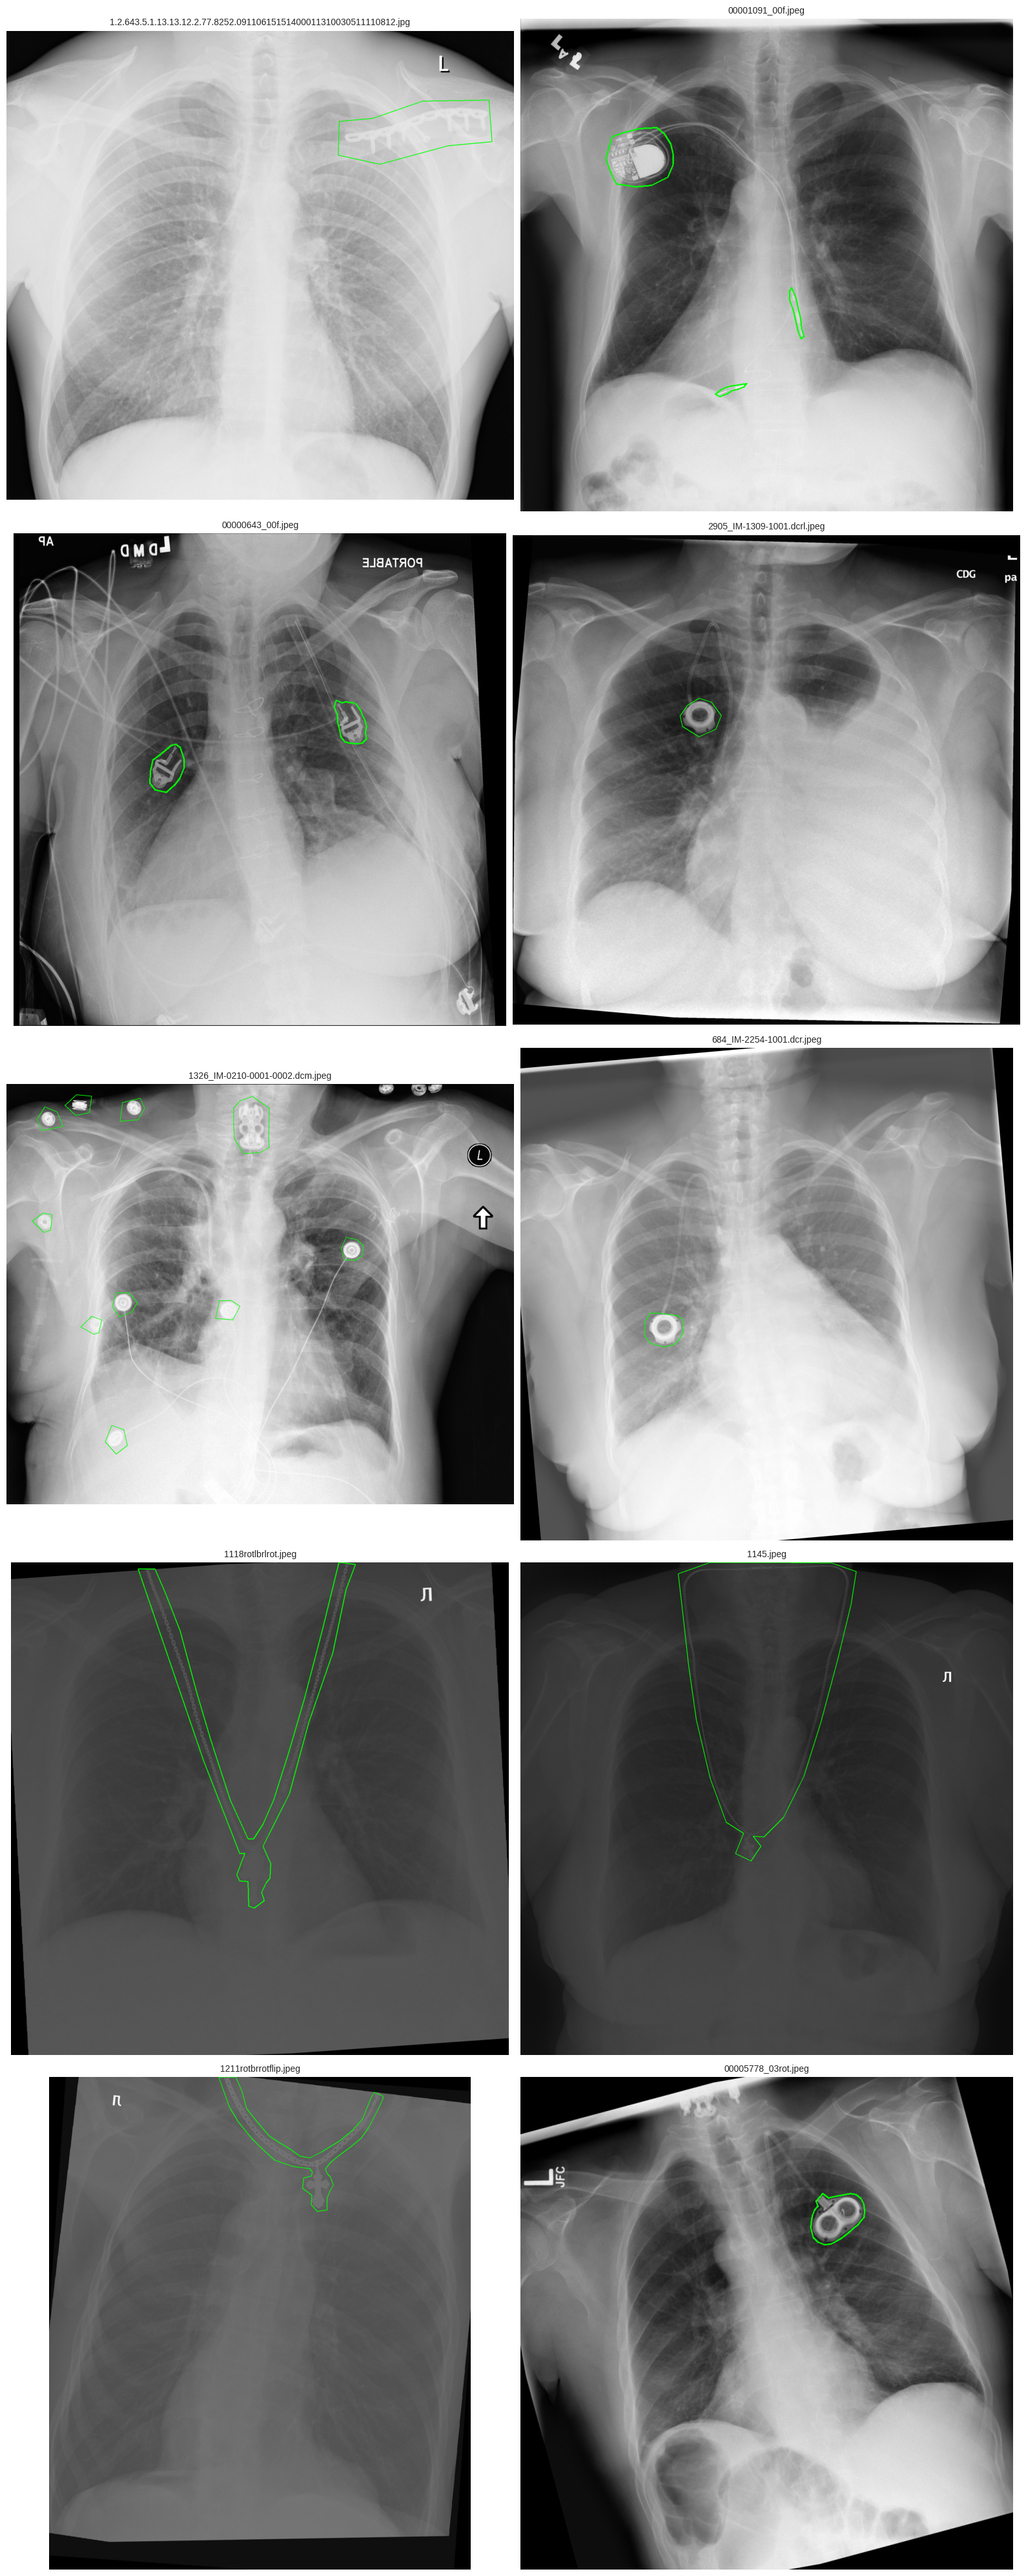

In [ ]:
"""
Посмотрим на случайные фото
"""

NUM_SAMPLES_TO_SHOW = 10 
IMG_SIZE = (8, 8)

images_with_labels = [
    p for p in image_paths if (LABELS_DIR / (p.stem + ".txt")).exists()
]

samples_to_show = random.sample(images_with_labels, min(NUM_SAMPLES_TO_SHOW, len(images_with_labels)))
cols = 2
rows = (len(samples_to_show) + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(IMG_SIZE[0] * cols, IMG_SIZE[1] * rows))
axes = axes.flatten()

for i, img_path in enumerate(samples_to_show):
    ax = axes[i]
    image = cv2.imread(str(img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape
    label_path = LABELS_DIR / (img_path.stem + ".txt")
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            coords_normalized = np.array([float(p) for p in parts[1:]])
            
            coords_pixel = coords_normalized.reshape(-1, 2)
            coords_pixel[:, 0] *= w 
            coords_pixel[:, 1] *= h 

            pts = coords_pixel.astype(np.int32)
            pts = pts.reshape((-1, 1, 2))
            
            cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=2)

    ax.imshow(image)
    ax.set_title(img_path.name, fontsize=10)
    ax.axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
"""
Сделаем сжатие до 1024
"""

sample_paths = image_paths
sizes = []

print(f"Анализ размеров {len(sample_paths)} изображений...")
for path in sample_paths:
    img = cv2.imread(str(path))
    height, width, _ = img.shape
    sizes.append({'width': width, 'height': height})

df_sizes = pd.DataFrame(sizes)

print("\n--- Статистика по размерам изображений ---")
print(df_sizes.describe())

Анализ размеров 784 изображений...



--- Статистика по размерам изображений ---
             width       height
count   784.000000   784.000000
mean   1778.501276  1769.767857
std     425.590138   418.713126
min    1024.000000   920.000000
25%    1540.000000  1524.000000
50%    2000.000000  2000.000000
75%    2012.000000  2012.000000
max    2496.000000  2496.000000
